# **Ada Project : Creative extension**
## Milestone P3

### **Supplementary method :** Decision tree

The idea of the original paper is to demonstarte (if possible) that there is a racial profiling trend across the united states, the authors do so by using severall methods that mostly take data across all available states. We have decided here to limit the search to one state, as we think that there may be different trends in the different states (As demonstrated for instance by the marijuane legalisation/search rate test). We also decided to implement a method that the paper hasn't used: The decision tree, which we think is a robust statistical test that correspond to the data we have. We know that our conclusions won't be able to caracterize the polices officers behaviour across the states but only to the specifical instance of the washington state patrol. 

In [33]:
#We first import all the libraries we will need

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

import warnings
import random

from datetime import datetime, date, time

from sklearn.tree import DecisionTreeClassifier, plot_tree  
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn import preprocessing

warnings.filterwarnings('ignore')

### **Step 1**:  Source of Data
The original paper gives a link to the source of their data the Stanford Open Policing project :https://openpolicing.stanford.edu/data/. Sevrall million of stops are categorized there but as we said we decided to limit ourselves to only one state, which we thought needed to be heavily populated and where state patrols had recorded  a lot of stops owith information on the racial appearence of the subjects, the time of the stop, the subject age, the subjet sex and if a search had been conducted. Our choice was therefore the state of washington and the 11 million state patrol stopps.

But this also meant that the file containing all these stops was really large and the computation time being so long we had to take only parts of the original csv.  To achieve this, as the data is sorted by date, we sampled the orignal dataset randomly and took a about 500 000. That is aproximately 4,5% . 

Some of us also had enough good computers to use the whole dataset, so we made it possible to switch.

In [2]:
#We first define which computer is used. For the final rendering we will uses Nathan computer with the whole dataset but we still decided to keep the other options.
computer ='Nathan'

In [3]:
#Loading our dataset splited in a random way for the different computers:
if computer =='Alex':
    filename = "Desktop/m_3/wa.csv" #path on Alex computer
    
    n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
    s = 500000 #desired sample size, longer sample sizes will significantly increase runtime
    skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list

    wa = pd.read_csv(filename, skiprows=skip) #uncomment this line and comment the following line for only importing s samples
    
elif computer == 'Jean':
    filename = "/Users/jeandevillard/Desktop/m_3/wa.csv" #path on Jean computer
    wa = pd.read_csv(filename)

elif computer == 'Nathan':
    filename = "data/wa_statewide_2020_04_01.csv" #where your data should be :)
    wa = pd.read_csv(filename)

In [4]:
wa.head()

,raw_row_number,date,time,location,lat,lng,county_name,subject_age,subject_race,subject_sex,...,frisk_performed,search_conducted,search_basis,raw_officer_race,raw_officer_gender,raw_contact_type,raw_driver_race,raw_driver_gender,raw_search_type,raw_enforcements
0,1,2009-10-27,11:00:00,S-012-344,46.114221,-118.224510,Walla Walla County,30.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,-|-|-
1,2,2009-10-04,21:00:00,I-090-10,47.580522,-122.170289,King County,29.0,black,male,...,False,False,NaN,WHITE,-,--,African American,M,N,-|-
2,3,2009-10-04,03:00:00,I-090-72,47.250003,-121.189883,Kittitas County,25.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,NaN
3,4,2009-10-04,13:00:00,S-014-3,45.615344,-122.612893,Clark County,19.0,white,female,...,False,False,NaN,WHITE,-,--,White,F,N,-|-|-|-|-|-
4,5,2009-10-11,08:00:00,S-003-40,47.590284,-122.698671,Kitsap County,25.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,-|-


Before continuing we quickly check the diferent data types for each column that we have in our main dataframe.

In [5]:
wa.dtypes

raw_row_number          int64
date                   object
time                   object
location               object
lat                   float64
lng                   float64
county_name            object
subject_age           float64
subject_race           object
subject_sex            object
officer_race           object
officer_sex            object
department_name        object
type                   object
violation              object
arrest_made            object
citation_issued          bool
warning_issued           bool
outcome                object
contraband_found       object
frisk_performed          bool
search_conducted         bool
search_basis           object
raw_officer_race       object
raw_officer_gender     object
raw_contact_type       object
raw_driver_race        object
raw_driver_gender      object
raw_search_type        object
raw_enforcements       object
dtype: object

In [6]:
#It is important for the followings parts to get the columns of date and time into a datetime type.
#There ara many ways to do this tranformation of the data type but we decide to use the pandas function pd.to_datetime:

#First for the date column:
wa_datetime = pd.to_datetime(wa.date)
wa.date = wa_datetime

We verify that the transformation ahs worked.

In [7]:
wa.head()

,raw_row_number,date,time,location,lat,lng,county_name,subject_age,subject_race,subject_sex,...,frisk_performed,search_conducted,search_basis,raw_officer_race,raw_officer_gender,raw_contact_type,raw_driver_race,raw_driver_gender,raw_search_type,raw_enforcements
0,1,2009-10-27,11:00:00,S-012-344,46.114221,-118.224510,Walla Walla County,30.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,-|-|-
1,2,2009-10-04,21:00:00,I-090-10,47.580522,-122.170289,King County,29.0,black,male,...,False,False,NaN,WHITE,-,--,African American,M,N,-|-
2,3,2009-10-04,03:00:00,I-090-72,47.250003,-121.189883,Kittitas County,25.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,NaN
3,4,2009-10-04,13:00:00,S-014-3,45.615344,-122.612893,Clark County,19.0,white,female,...,False,False,NaN,WHITE,-,--,White,F,N,-|-|-|-|-|-
4,5,2009-10-11,08:00:00,S-003-40,47.590284,-122.698671,Kitsap County,25.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,-|-


In [8]:
wa.dtypes

raw_row_number                 int64
date                  datetime64[ns]
time                          object
location                      object
lat                          float64
lng                          float64
county_name                   object
subject_age                  float64
subject_race                  object
subject_sex                   object
officer_race                  object
officer_sex                   object
department_name               object
type                          object
violation                     object
arrest_made                   object
citation_issued                 bool
warning_issued                  bool
outcome                       object
contraband_found              object
frisk_performed                 bool
search_conducted                bool
search_basis                  object
raw_officer_race              object
raw_officer_gender            object
raw_contact_type              object
raw_driver_race               object
r

In our analysis we want to take into acount the effect of legalization so we want to add a column that contains the boolean information on this aspect.

In [9]:
#Creating a variable with this information to compare after with our dataframe values.
a = '2012-12-06'
a_datetime = pd.to_datetime(a)
a = a_datetime
a

Timestamp('2012-12-06 00:00:00')

To create this new column we will use the tool date.toordinal because is easier for python  works with this type of data and also is easier to make comparation. We will pass to this new format the date column creating a new column with a new name date_ordinal. Also we will do the same with the date that marijuana becomes legal in Washignton as we will use this date to make an analysis and create new columns with useful information for the final model.

In [10]:
#Creating the new column with the date_ordinal format:
wa['date_ordinal'] = wa['date'].apply(lambda date: date.toordinal())

#Convert the date of marijuana legalization in a date_odinal format:
a_ordinal = a.toordinal()

We have to check if we get the format that we want.

In [11]:
wa.date_ordinal.head()

0    733707
1    733684
2    733684
3    733684
4    733691
Name: date_ordinal, dtype: int64

In [12]:
a_ordinal

734843

As we can see we get the values in a more manageable format to make operations. We will create the column of pre_legalization.

In [13]:
wa['pre_legalization'] = wa.date_ordinal.apply(lambda x: x < a_ordinal)
wa.pre_legalization

0            True
1            True
2            True
3            True
4            True
            ...  
11333420    False
11333421    False
11333422    False
11333423    False
11333424    False
Name: pre_legalization, Length: 11333425, dtype: bool

As we can see we get this new column that we will use later, but the next step is to calculate the time in years after legalitzation for each stop that happens in this period. For the other values that we will obtain during the period before legalitzation we will put a 0 value to represent this fact.

In [14]:
#We will call this column like years_after_legalization:
wa['years_after_legalization'] = (wa['date_ordinal']-a_ordinal)/365
wa.years_after_legalization

0          -3.112329
1          -3.175342
2          -3.175342
3          -3.175342
4          -3.156164
              ...   
11333420    5.794521
11333421    5.805479
11333422    5.808219
11333423    5.808219
11333424    5.808219
Name: years_after_legalization, Length: 11333425, dtype: float64

Now we have to put in a better way, where all the values under 0 will be zero to get a more clean column.

In [15]:
wa['years_after_legalization'] = wa['years_after_legalization'].clip(lower = 0)

Finally, the last step in this section will be to see if the columns with the expected values have been obtained.

In [16]:
#wa

We can show that the columns obtained are in a correct way like we expected and rigth now we are able to begin with the analysis.

### **Step 2**: Statistics

We will now perform a decision tree analysis of our data. This is convenient because we have both categorical and numerical variables as inputs, and because the decision tree will ultimately return the factors which are more important to determine if a subject will be searched or not.

We could have used a random forest analysis for better precision, but we found the decision tree analysis to be more convenient. The main reason is that decision trees are easy to represent, and are white box models, whereas random forests are more accurate but they are black box models, harder to represent, and impossible to run by hand.

We will use sklearn to do this

The first thing we will need to do is to split our data into a training and testing set.

This is extremely important to prevent overfitting, which is the main risk of a decision tree analysis (most of the work we will do to prevent this will be afterwards on hyperparameter tuning)

We will divide our data into 3 sets :
A training set to train our decision tree classifier
A validation set to tune our hyperparameters
A testing set to check our results on "never seen before" data

Since the dataset is so big, we will only use 10% of it as testing and 10% of it as validation.

We also set all random_state to 1. This is to ensure reproducibility in our data;


First we will reduce our dataset to only the interest parameters, while also dropping rows with incomplete values


//To do : 
Decision tree 


randomized search for hyperparameter tuning

plotting of the final decision tree//

In [17]:
wa_reduced = wa[['subject_age','subject_race','subject_sex','pre_legalization','years_after_legalization','search_conducted']]
wa_reduced = wa_reduced.dropna()
wa_reduced

,subject_age,subject_race,subject_sex,pre_legalization,years_after_legalization,search_conducted
0,30.0,white,male,True,0.000000,False
1,29.0,black,male,True,0.000000,False
2,25.0,white,male,True,0.000000,False
3,19.0,white,female,True,0.000000,False
4,25.0,white,male,True,0.000000,False
...,...,...,...,...,...,...
11333390,55.0,white,male,False,5.783562,False
11333391,44.0,white,female,False,5.797260,False
11333392,28.0,asian/pacific islander,female,False,5.800000,False
11333393,35.0,hispanic,male,False,5.800000,False


We also want to drop all races that are not white, hispanic, or black
Also all sexes that are not male or female (I did not notice any, but this is just a precaution)
This is for simplification purposes, and also to fit the study results as well as possible 

In [18]:
wa_reduced = wa_reduced[wa_reduced['subject_race'].isin(['black','hispanic','white'])]
wa_reduced = wa_reduced[wa_reduced['subject_sex'].isin(['male','female'])]

Unfortunately, sklearn does not handle categorical values for decision trees.

Hence, we have to use label encoding to switch categorical values into numerical values.
//Boolean values should work//

In [19]:
LE_race = preprocessing.LabelEncoder()
LE_sex = preprocessing.LabelEncoder()

wa_reduced['subject_race'] = LE_race.fit_transform(wa_reduced['subject_race'])
wa_reduced['subject_sex'] = LE_sex.fit_transform(wa_reduced['subject_sex'])

wa_reduced

,subject_age,subject_race,subject_sex,pre_legalization,years_after_legalization,search_conducted
0,30.0,2,1,True,0.000000,False
1,29.0,0,1,True,0.000000,False
2,25.0,2,1,True,0.000000,False
3,19.0,2,0,True,0.000000,False
4,25.0,2,1,True,0.000000,False
...,...,...,...,...,...,...
11333389,57.0,2,1,False,5.783562,False
11333390,55.0,2,1,False,5.783562,False
11333391,44.0,2,0,False,5.797260,False
11333393,35.0,1,1,False,5.800000,False


Hence : 

**race** : black = 0, white = 2, hispanic = 1

**sex** : female = 0, male = 1

We will be able to get back the original results by using the inverse_transform method

In [20]:

X = wa_reduced[['subject_age','subject_race','subject_sex','pre_legalization','years_after_legalization']].values
Y = wa_reduced[['search_conducted']].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 1) #training set : 80% of samples
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 1) #10% testing 10% validation


Now we will define our decision tree.

Most parameters (min_samples_leaf, min_samples_split) are not really important based on the number of samples

However, the ones that will really be important for our model are the max_tree_depth, criterion and splitter 

max_tree_depth is especially important because it will ultimately be this parameter that determines which factors are important to evaluate if a subject will be searched

In [21]:
WA_tree = DecisionTreeClassifier(random_state = 1)

First, we will evaluate the tree with only 3 levels. This is just to give us an idea of what the main parameters would be.

In [22]:
WA_tree_example = WA_tree
WA_tree_example.set_params(max_depth = 3)
WA_tree_example.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

Now we will tune the decision tree parameters,

To do so, we will perform a randomized search cross validation.

A grid search cross validation would have worked fine too, but based on the big number of samples a random search will be shorter to perform, and give sufficient results.



In [24]:
#distributions = {'max_tree_depth' : np.arange(1,10),'criterion' : ['gini,entropy'],'splitter' : ['best','random']}

### **Step 3**:  Visualization
We now want to visualize the results of our analysis

[Text(558.0, 380.52, 'X[0] <= 39.5\ngini = 0.057\nsamples = 5969201\nvalue = [5792766, 176435]'),
 Text(279.0, 271.8, 'X[1] <= 1.5\ngini = 0.071\nsamples = 3465355\nvalue = [3337882, 127473]'),
 Text(139.5, 163.07999999999998, 'X[2] <= 0.5\ngini = 0.1\nsamples = 684742\nvalue = [648552, 36190]'),
 Text(69.75, 54.360000000000014, 'gini = 0.06\nsamples = 187911\nvalue = [182106, 5805]'),
 Text(209.25, 54.360000000000014, 'gini = 0.115\nsamples = 496831\nvalue = [466446, 30385]'),
 Text(418.5, 163.07999999999998, 'X[2] <= 0.5\ngini = 0.064\nsamples = 2780613\nvalue = [2689330, 91283]'),
 Text(348.75, 54.360000000000014, 'gini = 0.049\nsamples = 1016584\nvalue = [991144, 25440]'),
 Text(488.25, 54.360000000000014, 'gini = 0.072\nsamples = 1764029\nvalue = [1698186, 65843]'),
 Text(837.0, 271.8, 'X[0] <= 56.5\ngini = 0.038\nsamples = 2503846\nvalue = [2454884, 48962]'),
 Text(697.5, 163.07999999999998, 'X[1] <= 0.5\ngini = 0.046\nsamples = 1676075\nvalue = [1636585, 39490]'),
 Text(627.75, 

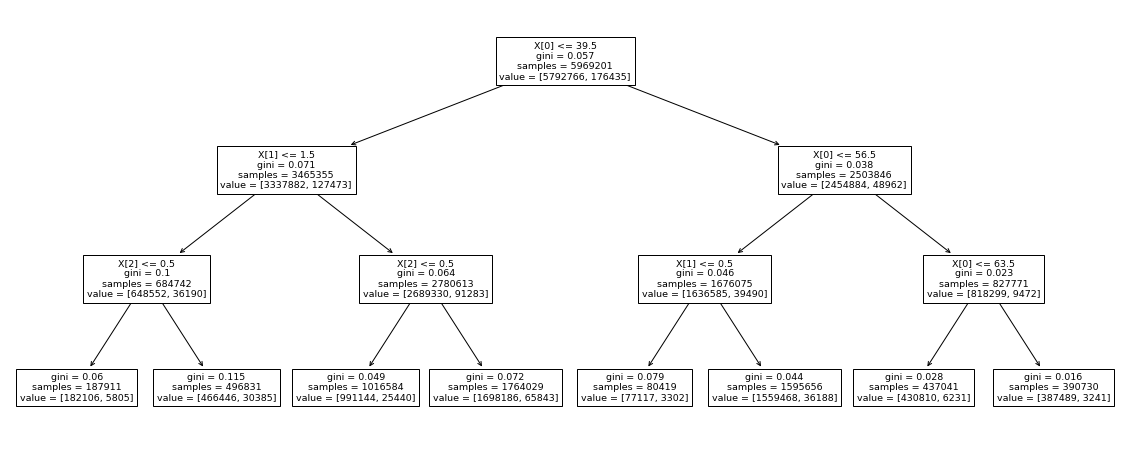

In [38]:
fig, axis = plt.subplots(figsize=(20, 8))
plot_tree(WA_tree_example, ax=axis)